Import libraries

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np


Create methods for later use

In [2]:
def LoadData(filename):
    df = pd.read_csv(filename)
    print("Data loaded successfully.")
    df = handle_missing_and_outliers(df)
    print(df.info())
    return df
    
def handle_missing_and_outliers(df): 
    # Removes duplicates
    df = df.drop_duplicates()

    # Fill missing numerical values with median
    numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())  # Updated to avoid FutureWarning

    # Fill missing ordinal (rating) values with mode
    ordinal_cols = ['Seat comfort', 'Food and drink', 'Gate location', 'Inflight wifi service',
                    'Inflight entertainment', 'Online support', 'Ease of Online booking',
                    'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                    'Cleanliness', 'Online boarding', 'Departure/Arrival time convenient']
    for col in ordinal_cols:
        df[col] = df[col].fillna(df[col].mode()[0])  # Updated to avoid FutureWarning

    # Fill missing categorical values with mode
    cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])  # Updated to avoid FutureWarning

    # Drop rows with missing target value
    df = df.dropna(subset=['satisfaction'])

    # Remove outliers using IQR
    for col in numerical_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]

    # Clip ordinal ratings to valid range (0 to 5)
    for col in ordinal_cols:
        df[col] = df[col].clip(0, 5)

    return df



In [ ]:
# Load the data correctly
filename = "../Data/Invistico_Airline.csv"
df = LoadData(filename)

# Encode categorical features
label_encoders = {}
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
display(df.describe())



Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 94710 entries, 0 to 129875
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction                       94710 non-null  object 
 1   Gender                             94710 non-null  object 
 2   Customer Type                      94710 non-null  object 
 3   Age                                94710 non-null  int64  
 4   Type of Travel                     94710 non-null  object 
 5   Class                              94710 non-null  object 
 6   Flight Distance                    94710 non-null  int64  
 7   Seat comfort                       94710 non-null  int64  
 8   Departure/Arrival time convenient  94710 non-null  int64  
 9   Food and drink                     94710 non-null  int64  
 10  Gate location                      94710 non-null  int64  
 11  Inflight wifi service           

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,94710.000000,94710.000000,94710.000000,94710.000000,94710.00000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000
mean,39.739278,1905.758558,2.862538,2.991859,2.85784,2.984183,3.266540,3.410622,3.542709,3.502450,3.502249,3.506567,3.716683,3.366719,3.741780,3.370658,2.199736,1.376518
std,15.124741,948.590420,1.410166,1.535182,1.45238,1.308105,1.316085,1.348974,1.304478,1.302056,1.263469,1.291579,1.158471,1.254916,1.144664,1.295887,4.901447,2.949893
min,7.000000,50.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1315.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,1884.000000,3.000000,3.000000,3.00000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,51.000000,2481.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,1.000000,0.000000
max,85.000000,4321.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,12.000000


Summary Statistics:


,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,94710.000000,94710.000000,94710.000000,94710.000000,94710.00000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000,94710.000000
mean,39.739278,1905.758558,2.862538,2.991859,2.85784,2.984183,3.266540,3.410622,3.542709,3.502450,3.502249,3.506567,3.716683,3.366719,3.741780,3.370658,2.199736,1.376518
std,15.124741,948.590420,1.410166,1.535182,1.45238,1.308105,1.316085,1.348974,1.304478,1.302056,1.263469,1.291579,1.158471,1.254916,1.144664,1.295887,4.901447,2.949893
min,7.000000,50.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1315.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,1884.000000,3.000000,3.000000,3.00000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,51.000000,2481.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,1.000000,0.000000
max,85.000000,4321.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,12.000000


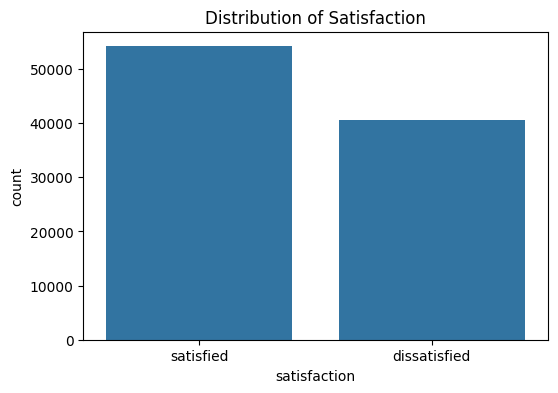

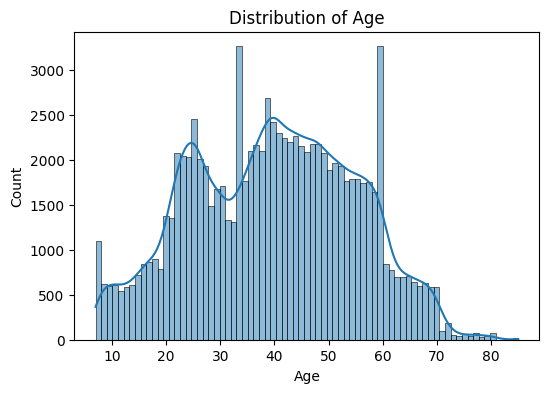

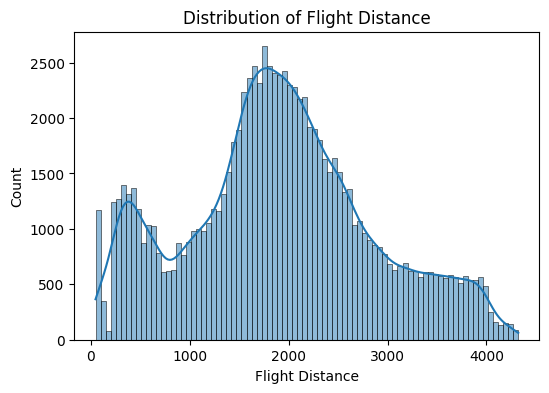

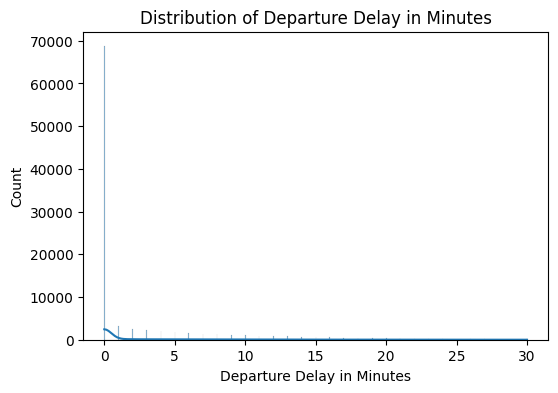

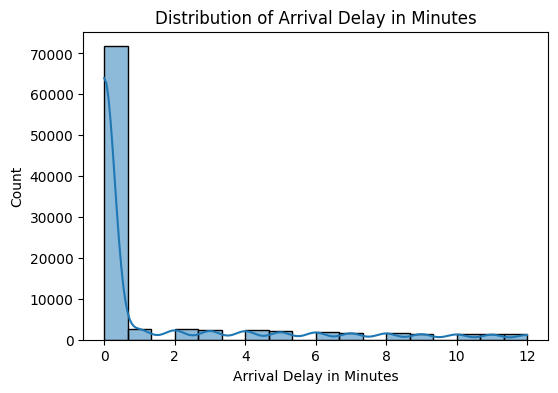

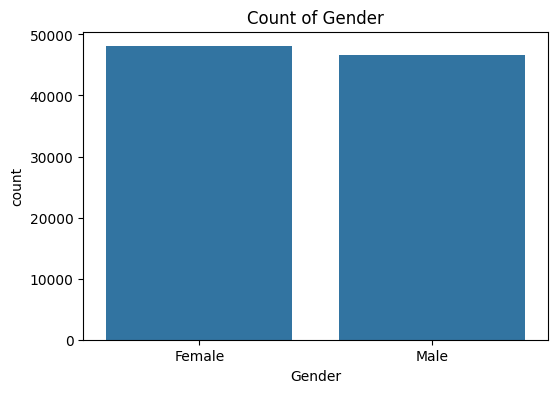

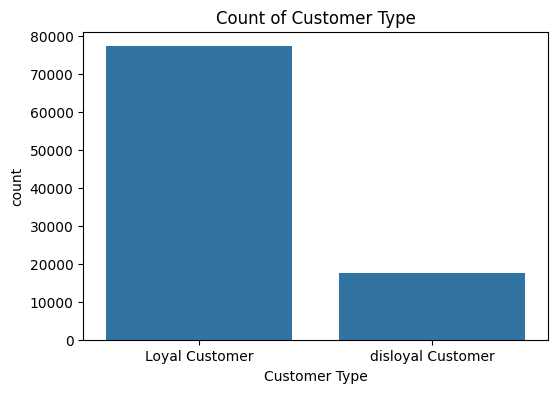

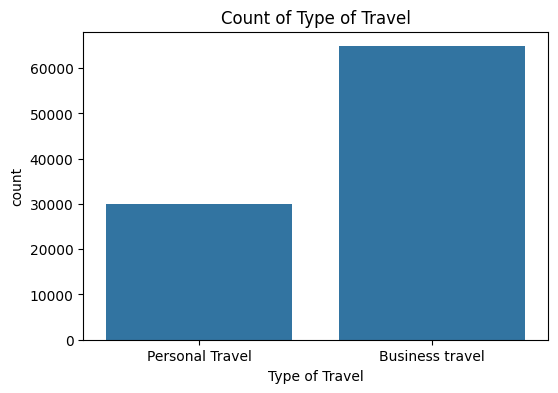

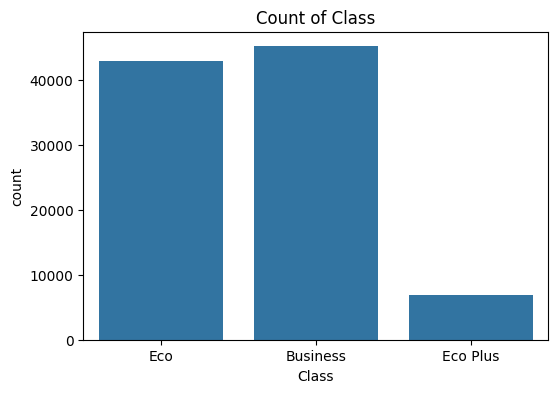

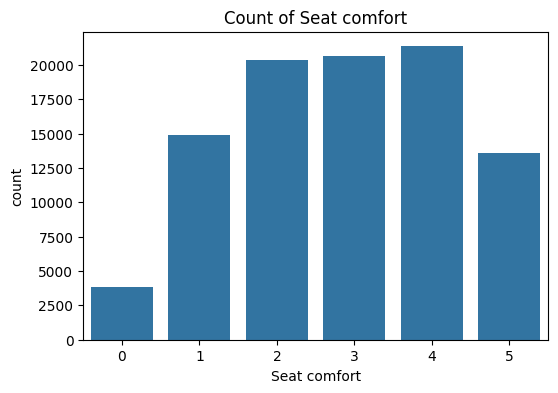

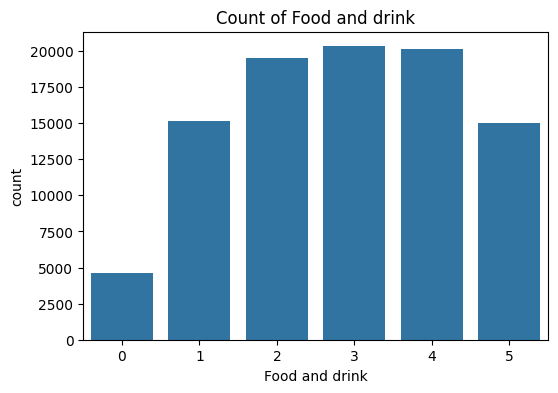

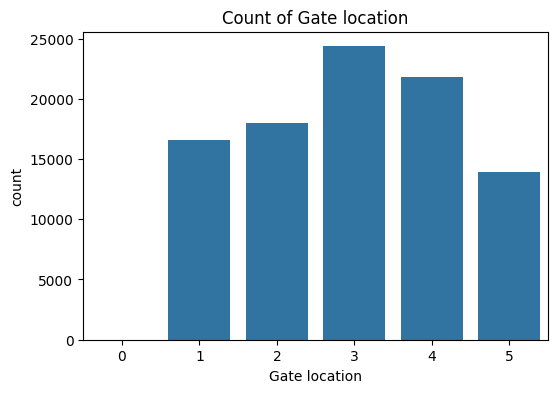

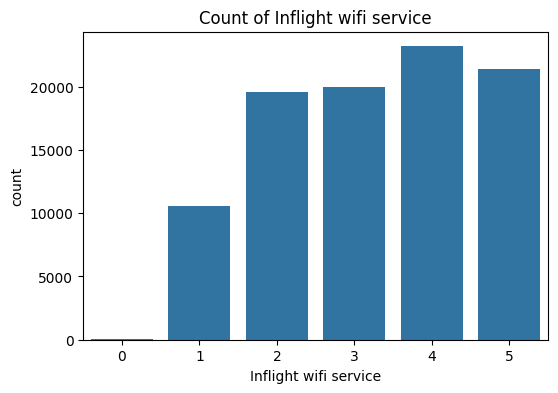

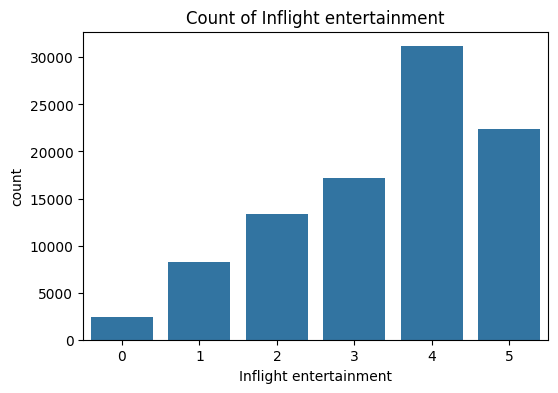

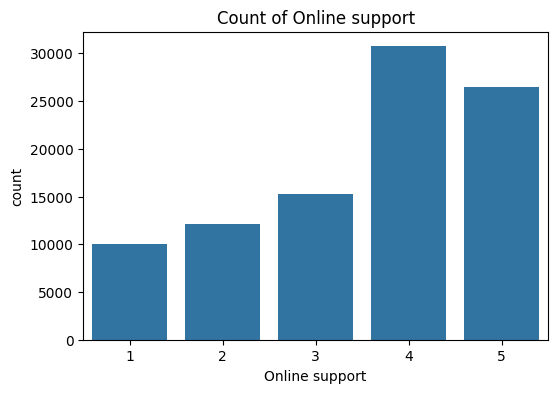

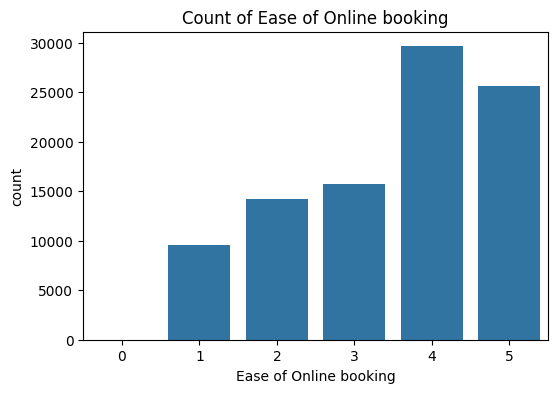

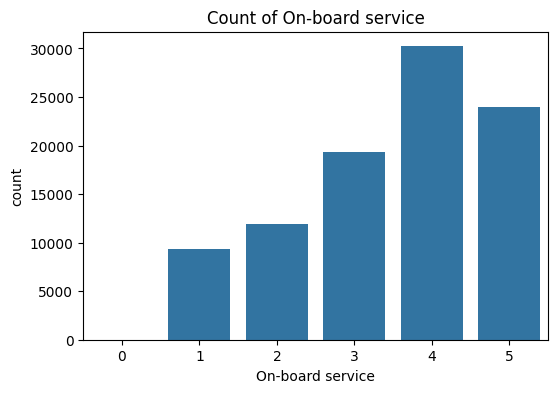

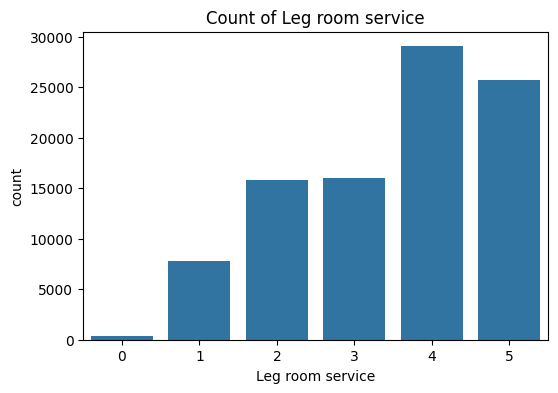

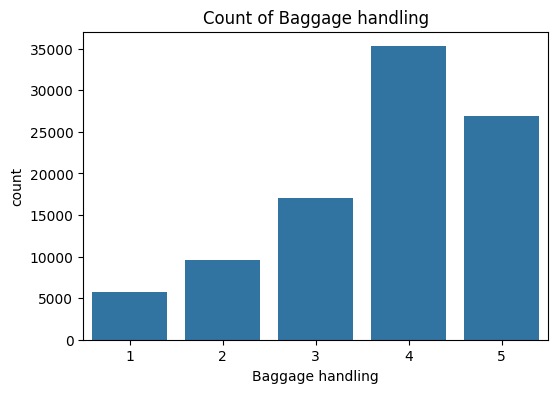

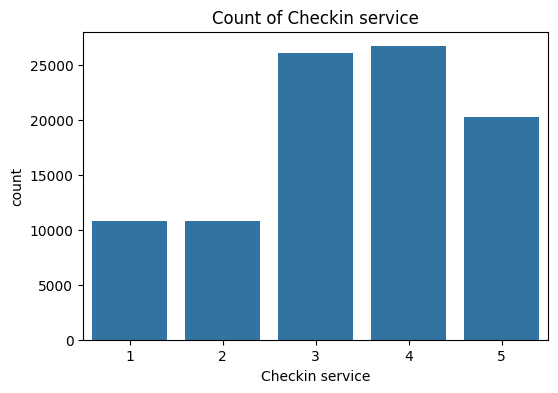

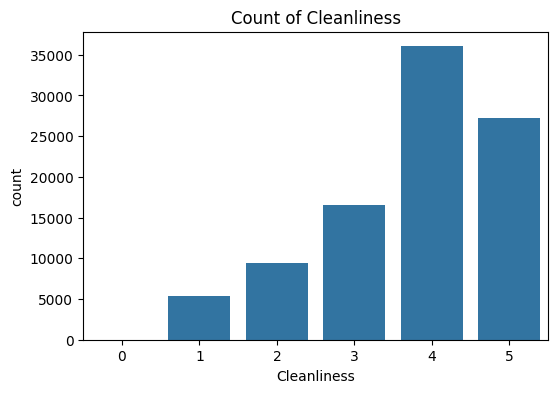

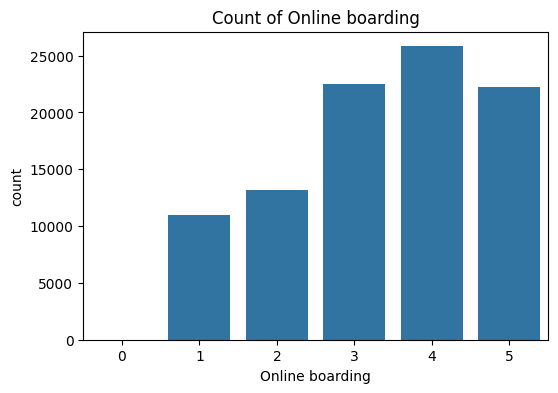

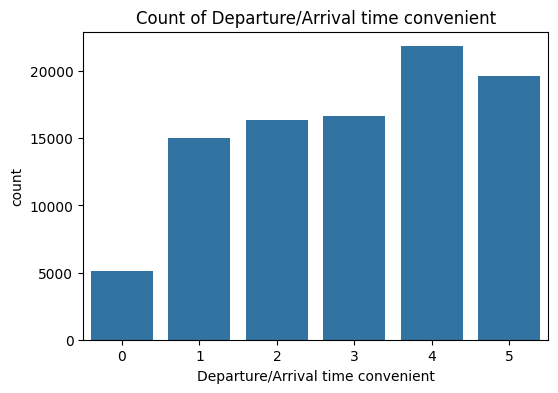

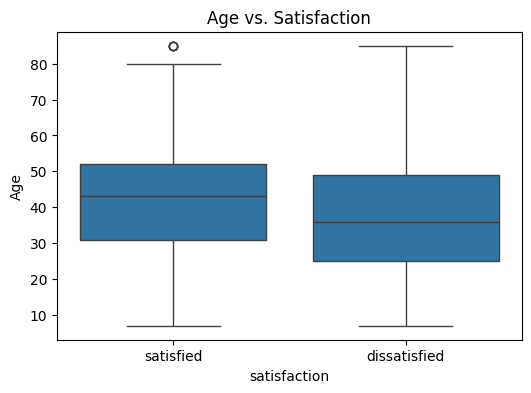

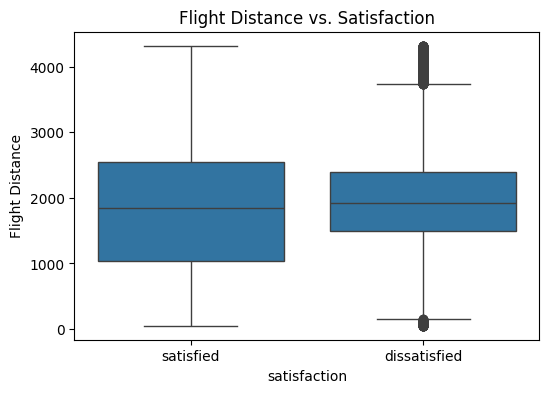

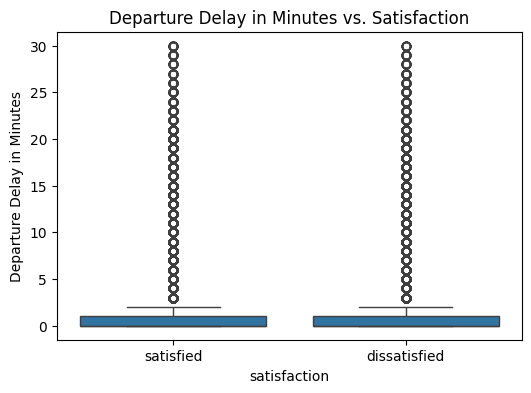

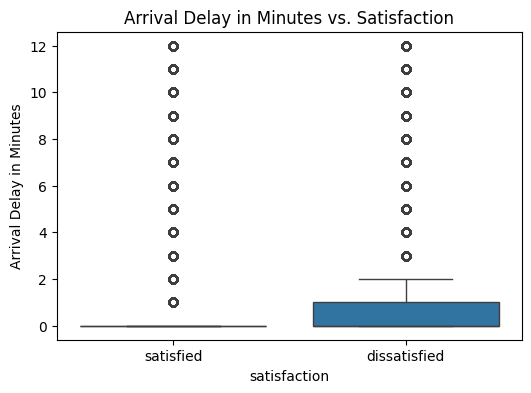

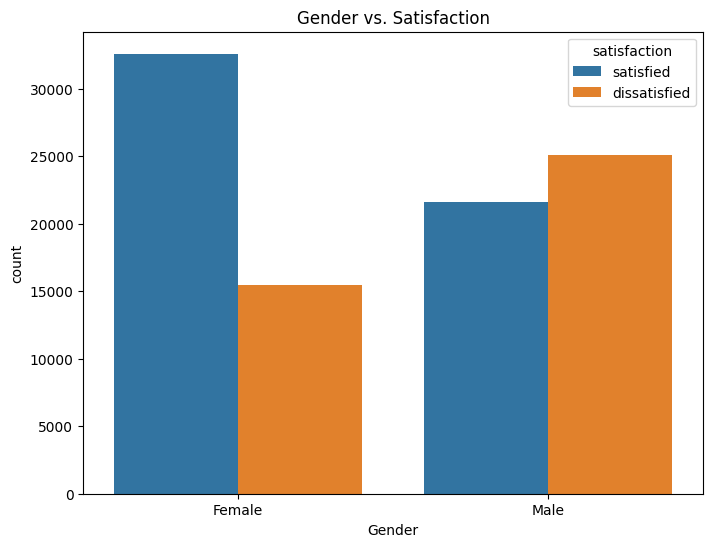

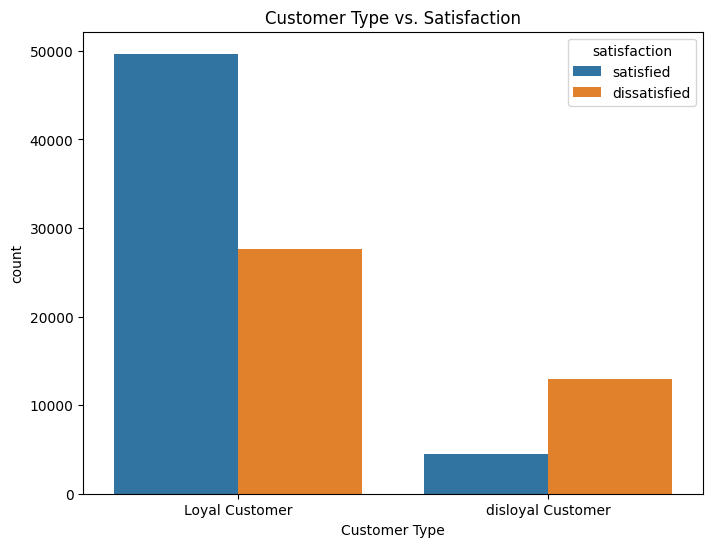

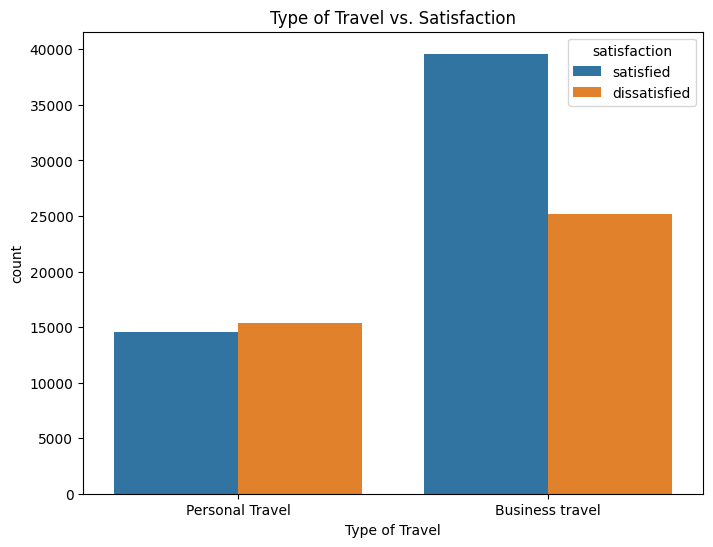

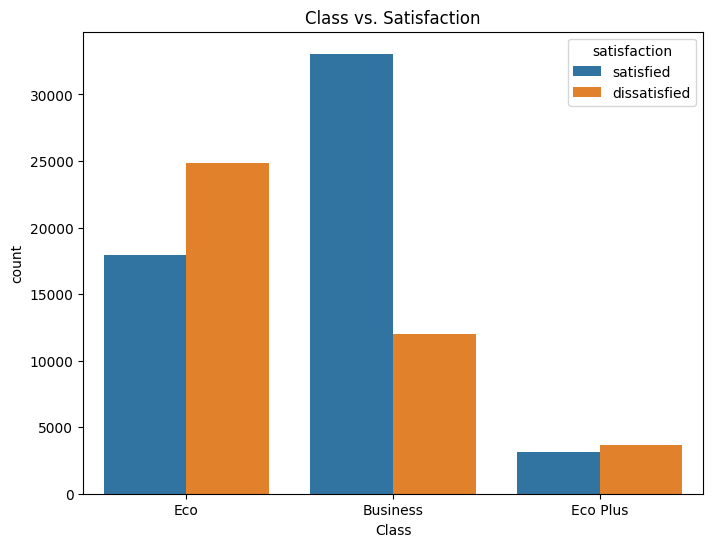

In [4]:
print("Summary Statistics:")
display(df.describe())

# Distribution of the target variable 'satisfaction'
plt.figure(figsize=(6, 4))
sns.countplot(x='satisfaction', data=df)
plt.title('Distribution of Satisfaction')
plt.show()

# Histograms for numerical features
numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Bar plots for categorical features
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.show()

# Bar plots for ordinal ratings
ordinal_cols = ['Seat comfort', 'Food and drink', 'Gate location', 'Inflight wifi service',
                'Inflight entertainment', 'Online support', 'Ease of Online booking',
                'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                'Cleanliness', 'Online boarding', 'Departure/Arrival time convenient']
for col in ordinal_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.show()

# Bivariate analysis: Numerical features vs. Satisfaction
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='satisfaction', y=col, data=df)
    plt.title(f'{col} vs. Satisfaction')
    plt.show()

# Categorical features vs. Satisfaction
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='satisfaction', data=df)
    plt.title(f'{col} vs. Satisfaction')
    plt.show()

In [ ]:
# Prepare features and target for modeling
X = df.drop('satisfaction', axis=1).astype('float32')
y = df['satisfaction'].astype('int32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Encode the target variable
le = LabelEncoder()
df['satisfaction'] = le.fit_transform(df['satisfaction'])  # e.g., 'satisfied' -> 1, 'unsatisfied' -> 0

# One-hot encode categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Define features (X) and target (y)
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (for models sensitive to scale, like Logistic Regression and Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.8344947735191638
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      8094
           1       0.85      0.86      0.86     10848

    accuracy                           0.83     18942
   macro avg       0.83      0.83      0.83     18942
weighted avg       0.83      0.83      0.83     18942



In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # No scaling needed
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9525921233238306
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      8094
           1       0.96      0.95      0.96     10848

    accuracy                           0.95     18942
   macro avg       0.95      0.95      0.95     18942
weighted avg       0.95      0.95      0.95     18942



In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)  # No scaling needed
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9531728434167459
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      8094
           1       0.97      0.95      0.96     10848

    accuracy                           0.95     18942
   macro avg       0.95      0.95      0.95     18942
weighted avg       0.95      0.95      0.95     18942



d:\Python\envs\ml-env-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:56:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

d:\Python\envs\ml-env-py311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.8570 - loss: 0.3180 - val_accuracy: 0.9252 - val_loss: 0.1821
Epoch 2/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 903us/step - accuracy: 0.9277 - loss: 0.1725 - val_accuracy: 0.9312 - val_loss: 0.1586
Epoch 3/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9358 - loss: 0.1506 - val_accuracy: 0.9354 - val_loss: 0.1452
Epoch 4/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 877us/step - accuracy: 0.9417 - loss: 0.1373 - val_accuracy: 0.9338 - val_loss: 0.1404
Epoch 5/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9443 - loss: 0.1287 - val_accuracy: 0.9380 - val_loss: 0.1364
Epoch 6/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - accuracy: 0.9459 - loss: 0.1231 - val_accuracy: 0.9423 - val_loss: 0.1323
Epoch 7/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step - accuracy: 0.9499 - loss: 0.1153 - val_accuracy: 0.9417 - val_loss: 0.1309
Epoch 8/20
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.9482 -

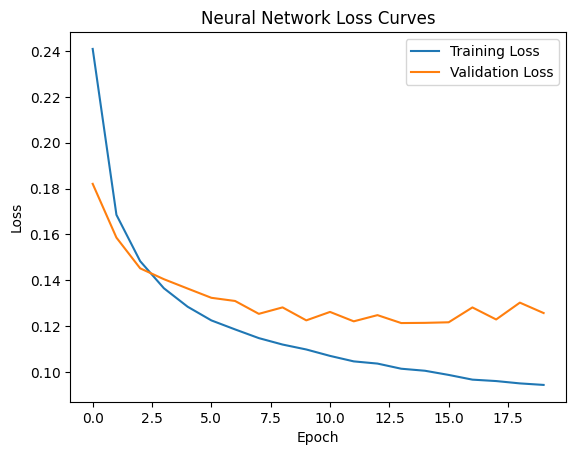

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

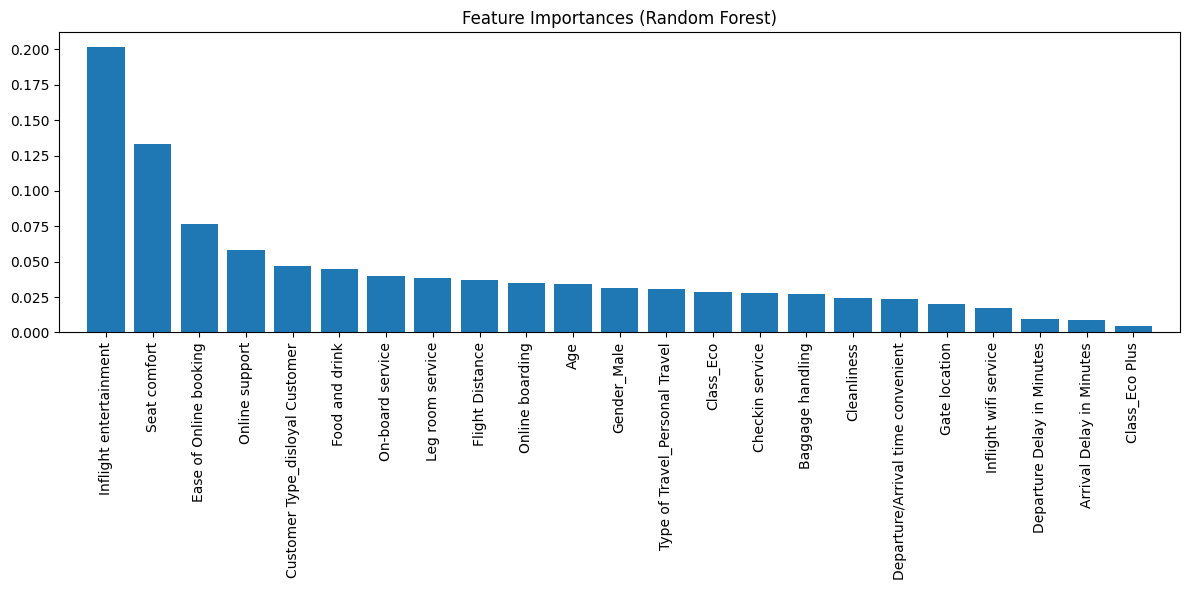

In [11]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()